# Store Item Demand Forecasting Challenge

## Autoregressive Integrated Moving Average (ARIMA)

<a href="https://www.kaggle.com/c/demand-forecasting-kernels-only">Link to competition on Kaggle.</a>

The <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">ARIMA</a> model is a generalisation of an ARMA model that can be applied to non-stationary time series.

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

pd.options.display.max_columns = 99
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data

In [52]:
df_train = pd.read_csv('data/train.csv', parse_dates=['date'], index_col=['date'])
df_test = pd.read_csv('data/test.csv', parse_dates=['date'], index_col=['date'])
df_train.shape, df_test.shape

((913000, 3), (45000, 3))

In [4]:
df_train.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


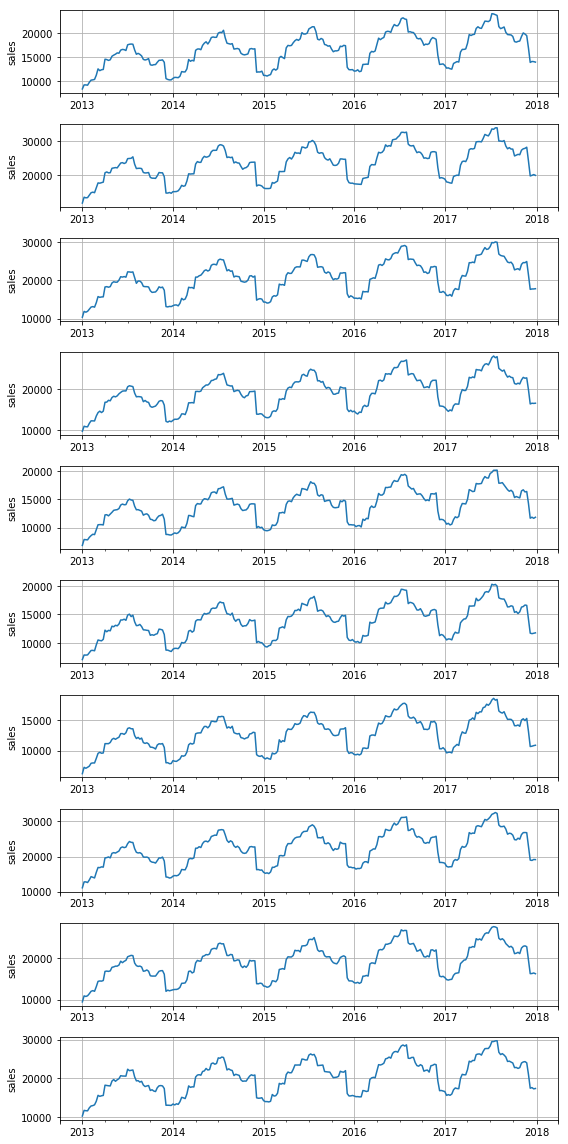

In [5]:
num_stores = len(df_train['store'].unique())
fig, axes = plt.subplots(num_stores, figsize=(8, 16))

for s in df_train['store'].unique():
    t = df_train.loc[df_train['store'] == s, 'sales'].resample('W').sum()
    ax = t.plot(ax=axes[s-1])
    ax.grid()
    ax.set_xlabel('')
    ax.set_ylabel('sales')
fig.tight_layout();

All stores appear to show identical trends and seasonality; they just differ in scale.

## ARIMA

We will build a SARIMA model for a single store and item, and then retrain it and generate predictions for all time series in the dataset.

### Example store and item

In [6]:
s1i1 = df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)]
s1i1.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


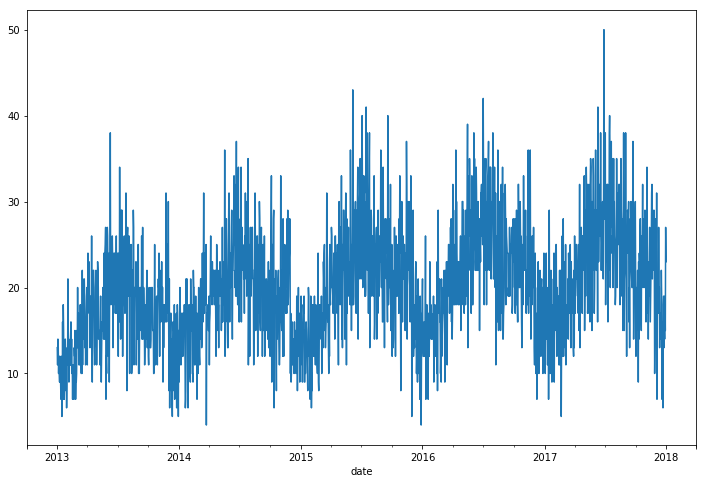

In [7]:
s1i1['sales'].plot();

### Time Series Decomposition

Decompose the example time series into trend, seasonal, and residual components.


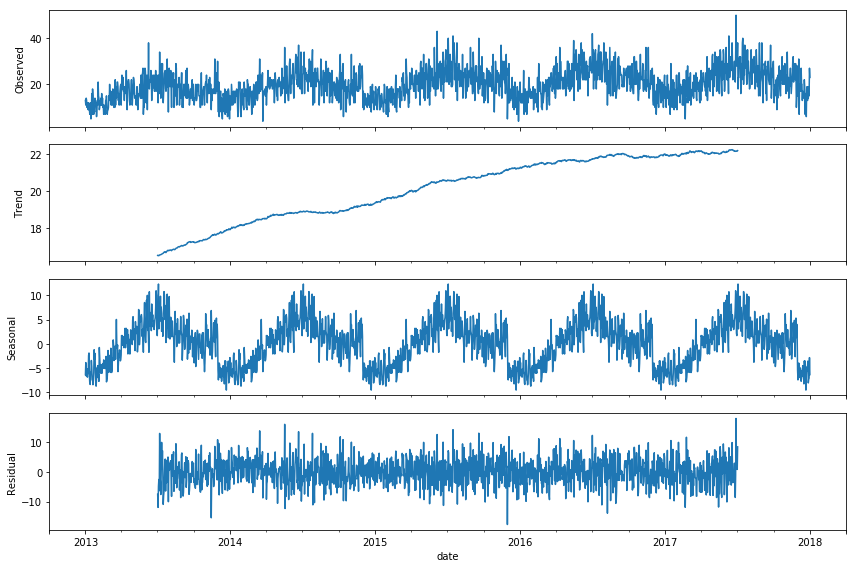

In [8]:
fig = seasonal_decompose(s1i1['sales'], model='additive', freq=365).plot()

There is clearly yearly seasonality and a non-stationary, upward trend. We can run a Dickey-Fuller test to examine the stationarity.

In [9]:
dftest = adfuller(s1i1['sales'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (10%)             -2.567625
Critical Value (5%)              -2.863145
dtype: float64

The Dickey-Fuller test p-value is lower than I would have expected, but the time series is not considered stationary using a 1% Critical Value and we can see visually that there is an upwards trend.

### Take first differences

We can try to remove the trend by applying a first difference to the time series.

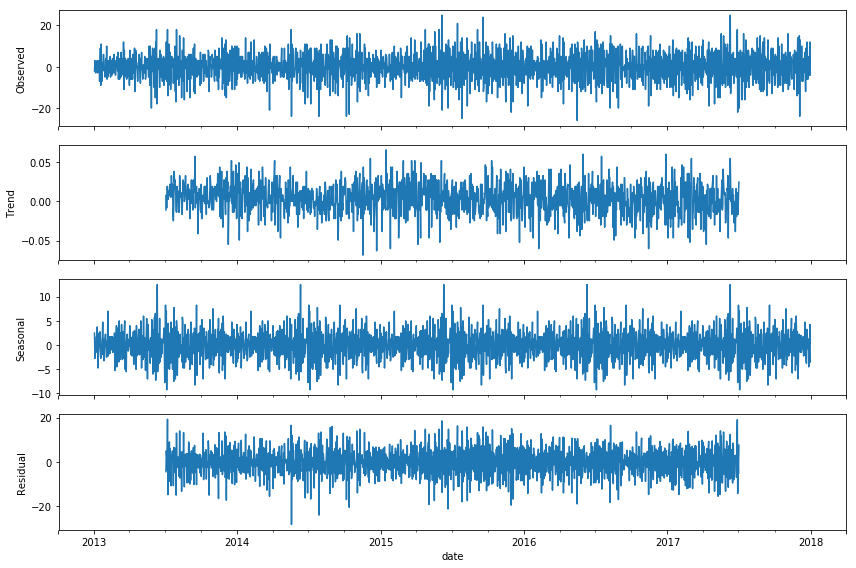

In [10]:
diff_1 = s1i1['sales'].diff(1)
diff_1.dropna(inplace=True)
fig = seasonal_decompose(diff_1, model='additive', freq=365).plot()

In [11]:
dftest = adfuller(diff_1, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -1.267679e+01
p-value                        1.210928e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (10%)          -2.567625e+00
Critical Value (5%)           -2.863145e+00
dtype: float64

The trend has been eliminated and the Dickey-Fuller test implies that the data is now stationary. Note that there is still some evidence of seasonality, however.

### Plot ACF and PACF

The <a href="https://en.wikipedia.org/wiki/Autocorrelation">Autocorrelation Function</a> (ACF) is the correlation of a signal with a delayed copy of itself as a function of delay.

The <a href="https://en.wikipedia.org/wiki/Partial_autocorrelation_function">Partial Autocorrelation Function</a> (PACF) is the partial correlation of a signal with a delayed copy of itself, controlling for the values of the time series at all shorter delays, as a function of delay.

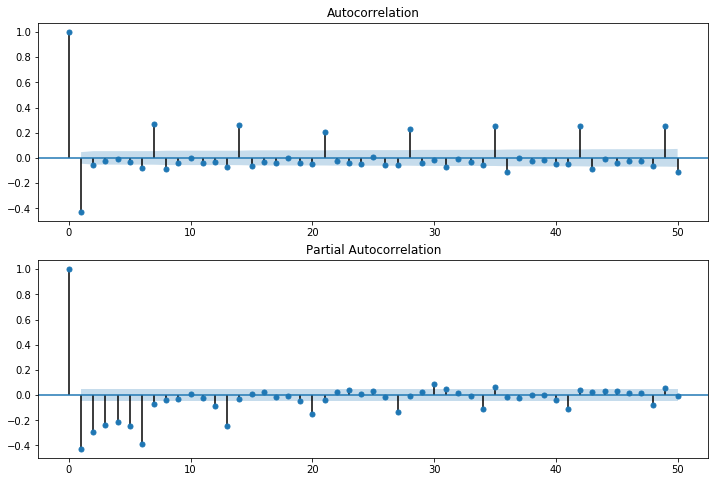

In [12]:
fig, ax = plt.subplots(2)
ax[0] = sm.graphics.tsa.plot_acf(diff_1, lags=50, ax=ax[0])
ax[1] = sm.graphics.tsa.plot_pacf(diff_1, lags=50, ax=ax[1])

Clearly there are seasonal patterns in the data. In this case, the ACF and PACF are too complex to infer the appropriate parameters for the ARIMA model.

### Build Model

We will implement grid search to identify the optimal parameters for our ARIMA(p,d,q) model, using the following possible values:

In [13]:
from itertools import product

ps = range(0, 7) # Up to 6 AR terms
d = 1            # Differencing is 1
qs = range(0, 7) # Up to 6 MA terms

params = product(ps, qs)
params_list = list(params)
print("Number of parameter combinations for grid search: {}".format(len(params_list)))

Number of parameter combinations for grid search: 49


In [14]:
def optimiseARIMA(ts, params_list, d):
    results = []
    best_aic = np.inf
    
    for param in params_list:
        try:
            arima = sm.tsa.ARIMA(ts, freq='D', order=(param[0], d, param[1])).fit()
        except:
            continue
        
        aic = arima.aic
        if aic < best_aic:
            best_model = arima
            best_aic = aic
            best_param = param
            
        results.append([param, arima.aic])
        
    df_results = pd.DataFrame(results)
    df_results.columns = ['parameters', 'aic']
    df_results = df_results.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return df_results

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
%%time
results = optimiseARIMA(s1i1['sales'], params_list, d)

Wall time: 3min 4s


In [17]:
results.head(10)

,parameters,aic
0,"(6, 6)",10932.853916
1,"(5, 5)",10962.729013
2,"(4, 5)",10992.497248
3,"(5, 4)",11062.094832
4,"(5, 3)",11062.533342
5,"(4, 4)",11064.496586
6,"(3, 3)",11066.521367
7,"(2, 3)",11069.324432
8,"(3, 5)",11070.506092
9,"(6, 3)",11159.316495


Unsurprisingly, the more complex models have the lowest AIC values. We will compare the training time of ARIMA(6,1,6) and ARIMA(5,1,5) to see if the slight performance increase justifies the longer training time.

In [18]:
%%time
arima = sm.tsa.ARIMA(s1i1['sales'], freq='D', order=(6, 1, 6)).fit()
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 6)   Log Likelihood               -5452.427
Method:                       css-mle   S.D. of innovations              4.779
Date:                Sat, 25 Aug 2018   AIC                          10932.854
Time:                        14:47:04   BIC                          11009.985
Sample:                    01-02-2013   HQIC                         10961.306
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.012      0.269      0.788      -0.020       0.026
ar.L1.D.sales    -0.2341        nan        nan        nan         nan         nan
ar.L2.D.sales    -0.6572      0.000  -22

In [19]:
%%time
arima = sm.tsa.ARIMA(s1i1['sales'], freq='D', order=(5, 1, 5)).fit()
print(arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -5469.365
Method:                       css-mle   S.D. of innovations              4.817
Date:                Sat, 25 Aug 2018   AIC                          10962.729
Time:                        14:47:09   BIC                          11028.841
Sample:                    01-02-2013   HQIC                         10987.117
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027        nan        nan        nan         nan         nan
ar.L1.D.sales     0.7515        nan        nan        nan         nan         nan
ar.L2.D.sales    -1.4032        nan     

Given that ARIMA(5,1,5) is ten times faster to train and only slightly worse, we will proceed with this model.

## Make Predictions

In [20]:
arima_results = df_test.reset_index()
arima_results['sales'] = 0

In [21]:
tic = time.time()

for s in arima_results['store'].unique():
    for i in arima_results['item'].unique():
        si = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        try:
            arima = sm.tsa.ARIMA(si, freq='D', order=(5, 1, 5)).fit()
        except:
            arima = sm.tsa.ARIMA(si, freq='D', order=(2, 1, 2)).fit()
            print("ARIMA(5,1,5) failed to converge for store {} item {}. ARIMA(2,1,2) used instead.".format(s, i))
        fcst = arima.predict(start='2018-01-01', end='2018-03-31', dynamic=True)
        arima_results.loc[(arima_results['store'] == s) & (arima_results['item'] == i), 'sales'] = fcst.values
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}m".format(s, i, (toc-tic)/60))

ARIMA(5,1,5) failed to converge for store 1 item 4. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 9. ARIMA(2,1,2) used instead.
Completed store 1 item 10. Cumulative time: 2.6m
ARIMA(5,1,5) failed to converge for store 1 item 17. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 19. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 20. ARIMA(2,1,2) used instead.
Completed store 1 item 20. Cumulative time: 4.4m
ARIMA(5,1,5) failed to converge for store 1 item 21. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 23. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 24. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 26. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 29. ARIMA(2,1,2) used instead.
ARIMA(5,1,5) failed to converge for store 1 item 30. ARIMA(2,1,2) used instead.
Completed store 1 item 3

In [22]:
arima_results.drop(['date', 'store', 'item'], axis=1, inplace=True)
arima_results.head()

,id,sales
0,0,-9.228479
1,1,-0.466224
2,2,3.095247
3,3,-0.483305
4,4,1.351417


In [23]:
arima_results.to_csv('arima_results.csv', index=False)

## ARIMAX

Autoregressive Integrated Moving Average with Explanatory Variable (ARIMAX) is an extended version of ARIMA that includes independent predictor variables.

### Prepare data

In [53]:
months = df_train.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = df_train.index

df_train['prev_quarter'] = df_train['sales'].shift(91)
df_train['prev_year'] = df_train['sales'].shift(364)
df_train = pd.concat([df_train, dummy_months], axis=1)
df_train.dropna(inplace=True)
df_train.head()

,store,item,sales,prev_quarter,prev_year,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
date,,,,,,,,,,,,,,,,,
2013-12-31,1,1,15,12.0,13.0,0,0,0,0,0,0,0,0,0,0,0,1
2014-01-01,1,1,9,11.0,11.0,1,0,0,0,0,0,0,0,0,0,0,0
2014-01-02,1,1,14,14.0,14.0,1,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,1,1,11,14.0,13.0,1,0,0,0,0,0,0,0,0,0,0,0
2014-01-04,1,1,20,14.0,10.0,1,0,0,0,0,0,0,0,0,0,0,0


In [109]:
import datetime

df_test_ex = df_test.copy()
months = df_test_ex.index.month
dummy_months = pd.get_dummies(months)
dummy_months.columns = ['month-%s' % m for m in dummy_months.columns]
dummy_months.index = df_test_ex.index

prev_quarter_dates = df_test_ex.index - datetime.timedelta(days=91)
prev_year_dates = df_test_ex.index - datetime.timedelta(days=364)
df_test_ex['prev_quarter'] = df_train.loc[df_train.index.isin(prev_quarter_dates), 'sales'].values
df_test_ex['prev_year'] = df_train.loc[df_train.index.isin(prev_year_dates), 'sales'].values
df_test_ex = pd.concat([df_test_ex, dummy_months], axis=1)
for m in range(4, 13):
    df_test_ex['month-%s' % m] = 0
df_test_ex.head()

,id,store,item,prev_quarter,prev_year,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
date,,,,,,,,,,,,,,,,,
2018-01-01,0,1,1,12,15,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-02,1,1,1,18,10,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,2,1,1,15,16,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-04,3,1,1,20,14,1,0,0,0,0,0,0,0,0,0,0,0
2018-01-05,4,1,1,19,24,1,0,0,0,0,0,0,0,0,0,0,0


### Build model

In [105]:
%%time
exog_s1i1 = df_train.loc[(df_train['store'] == 1) & (df_train['item'] == 1)].drop(['store', 'item', 'sales'], axis=1)
arimax = sm.tsa.statespace.SARIMAX(s1i1['sales'].loc['2013-12-31':], exog=exog_s1i1,
                                   enforce_invertibility=False, enforce_stationarity=False, freq='D',
                                   order=(7,0,0)).fit()
print(arimax.summary())

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1462
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -4371.661
Date:                Sat, 25 Aug 2018   AIC                           8787.321
Time:                        17:34:57   BIC                           8903.542
Sample:                    12-31-2013   HQIC                          8830.684
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
prev_quarter     0.2196      0.025      8.617      0.000       0.170       0.270
prev_year        0.2269      0.026      8.887      0.000       0.177       0.277
month-1          7.2187      0.808      8.93

## Make Predictions

In [106]:
arimax_results = df_test.reset_index()
arimax_results['sales'] = 0

In [112]:
tic = time.time()

for s in arimax_results['store'].unique():
    for i in arimax_results['item'].unique():
        endog = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i), 'sales']
        exog = df_train.loc[(df_train['store'] == s) & (df_train['item'] == i)].drop(['store', 'item', 'sales'], axis=1)
        arimax = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog,
                                           enforce_invertibility=False, enforce_stationarity=False, freq='D',
                                           order=(7,0,0)).fit()
        exog_test = df_test_ex.loc[(df_test_ex['store'] == s) & (df_test_ex['item'] == i)].drop(['id', 'store', 'item'], axis=1)
        fcst = arimax.predict(start='2018-01-01', end='2018-03-31', dynamic=True, exog=exog_test)
        arimax_results.loc[(arimax_results['store'] == s) & (arimax_results['item'] == i), 'sales'] = fcst.values
        
        toc = time.time()
        if i % 10 == 0:
            print("Completed store {} item {}. Cumulative time: {:.1f}m".format(s, i, (toc-tic)/60))

Completed store 1 item 10. Cumulative time: 1.0m
Completed store 1 item 20. Cumulative time: 2.1m
Completed store 1 item 30. Cumulative time: 3.1m
Completed store 1 item 40. Cumulative time: 4.2m
Completed store 1 item 50. Cumulative time: 5.4m
Completed store 2 item 10. Cumulative time: 6.7m
Completed store 2 item 20. Cumulative time: 7.8m
Completed store 2 item 30. Cumulative time: 8.9m
Completed store 2 item 40. Cumulative time: 10.0m
Completed store 2 item 50. Cumulative time: 11.1m
Completed store 3 item 10. Cumulative time: 12.1m
Completed store 3 item 20. Cumulative time: 13.2m
Completed store 3 item 30. Cumulative time: 14.2m
Completed store 3 item 40. Cumulative time: 15.4m
Completed store 3 item 50. Cumulative time: 16.6m
Completed store 4 item 10. Cumulative time: 17.8m
Completed store 4 item 20. Cumulative time: 19.0m
Completed store 4 item 30. Cumulative time: 20.1m
Completed store 4 item 40. Cumulative time: 21.3m
Completed store 4 item 50. Cumulative time: 22.4m
Complete

In [113]:
arimax_results.drop(['date', 'store', 'item'], axis=1, inplace=True)
arimax_results.head()

,id,sales
0,0,13.128085
1,1,13.114750
2,2,13.286933
3,3,15.023433
4,4,16.593664


In [114]:
arimax_results.to_csv('arimax_results.csv', index=False)

Scores 16.15297 on the leaderboard.

### Example forecast

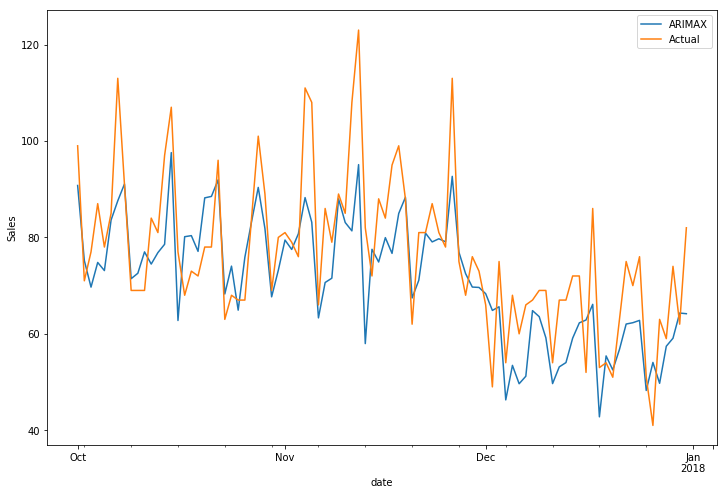

In [115]:
exog = df_train.loc[(df_train['store'] == 10) & (df_train['item'] == 50)].drop(['store', 'item', 'sales'], axis=1)
forecast = arimax.predict(start='2017-10-01', end='2017-12-31', dynamic=True, exog=exog)
actual = df_train.loc[(df_train['store'] == 10) & (df_train['item'] == 50), 'sales']

forecast.plot()
actual.loc['2017-10-01':].plot()
plt.legend(['ARIMAX', 'Actual'])
plt.ylabel('Sales');